In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from mpl_toolkits.mplot3d import Axes3D




In [33]:
def bifurcation_plot(f,df_dx,r,x,rlabel='r'):
    """ produce a bifurcation diagram for a function f(r,x) given
        f and its partial derivative f_x(r,x) over a domain given by numpy arrays r and x
        
        f(r,x)  :  RHS function of autonomous ode dx/dt = f(r,x)
        df_dx(r,x):  partial derivative of f with respect to x
        r       :  numpy array giving r coordinates of domain
        x       :  numpy array giving x coordinates of domain
        rlabel  :  string for x axis parameter label
    """
    # set up a mesh grid and extract the 0 level set of f
    R,X = np.meshgrid(r,x)
    plt.figure()
    CS = plt.contour(R,X,f(R,X),[0],colors='k')
    plt.clf()
    plt.xlabel('parameter {0}'.format(rlabel))
    plt.ylabel('x')
    
    c0 = CS.collections[0]
    # for each path in the contour extract vertices and mask by the sign of df/dx
    for path in c0.get_paths():
        vertices = path.vertices
        vr = vertices[:,0]
        vx = vertices[:,1]
        mask = np.sign(df_dx(vr,vx))
        stable = mask < 0.
        unstable = mask > 0.
        
        # plot the stable and unstable branches for each path
        plt.plot(vr[stable],vx[stable],'b')
        # plt.hold()
        plt.plot(vr[unstable],vx[unstable],'b--')
        
    plt.legend(('stable','unstable'),loc='best')
    plt.xlim(r[0],r[-1])
    plt.ylim(x[0],x[-1])
    plt.grid()


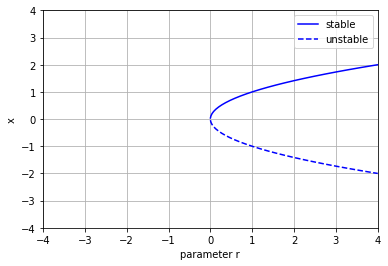

In [37]:
f = lambda r,x: r - x*x
df_dx = lambda r,x: -2.*x

x = np.linspace(-4,4,100)
r = np.linspace(-4,4,100)

bifurcation_plot(f,df_dx,r,x)

In [13]:
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
     
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
     
    return [dx, dy, dz]
 


Text(0.5, 0.92, 'solve_ivp')

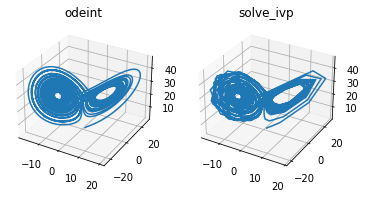

In [19]:
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0
 
p = (sigma, beta, rho)  # Parameters of the system
 
y0 = [1.0, 1.0, 1.0]  # Initial state of the system
t_span = (0.0, 40.0)
t = np.arange(0.0, 40.0, 0.01)
 
result_odeint = odeint(lorenz, y0, t, p, tfirst=True)
result_solve_ivp = solve_ivp(lorenz, t_span, y0, args=p)
 
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(result_odeint[:, 0],
        result_odeint[:, 1],
        result_odeint[:, 2])
ax.set_title("odeint")
 
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(result_solve_ivp.y[0, :],
        result_solve_ivp.y[1, :],
        result_solve_ivp.y[2, :])
ax.set_title("solve_ivp")

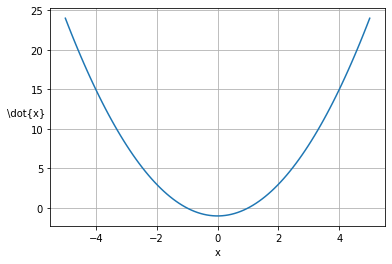

In [4]:
f = lambda x, r: r+x**2
tt = np.linspace(-5, 5, 100)
plt.plot(tt, f(tt,-1))
plt.grid()
plt.xlabel('x')
plt.ylabel(r'\dot{x}', rotation=0)
plt.show()

In [7]:
from IPython.display import HTML
from ipywidgets import interact
from matplotlib import animation as anim, rc


In [9]:
def itoEuler(model, y0, time, args=None,save_derivative=False):
    ret_val = np.zeros((len(time), len(y0)))
    y0 = np.array(y0)
    ret_val[0, :] = y0
    dt = time[1] - time[0]
    derivatives = np.zeros((len(time), len(y0)))
    for i in range(1, len(time)):
        derivatives[i-1, :] = np.array(model(ret_val[i - 1, :], time[i], *args) if args else model(ret_val[i - 1, :], time[i]),dtype=np.float128) 
        ret_val[i, :] = ret_val[i - 1, :] + derivatives[i-1, :] * dt
    return ret_val if not save_derivative else (ret_val,derivatives)


def center_axis(ax,xlab,ylab):
  # Move left y-axis and bottim x-axis to centre, passing through (0,0)
  ax.spines['left'].set_position('zero')
  ax.spines['bottom'].set_position('zero')

  # Eliminate upper and right axes
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')

  # Show ticks in the left and lower axes only
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

  ax.yaxis.set_label_coords(0,0.5)
  ax.xaxis.set_label_coords(0.5,0)
  ax.set_ylabel(xlab)
  ax.set_xlabel(ylab)

def abs_min_max(data):
  max_elem = np.nanmax(np.abs(data)[(data!=np.inf) & (data!=-np.inf)])
  return -max_elem,max_elem

def pitchfork_bifurcation_model(y,t,epsilon=1):
  x,y = y[0],y[1]
  dx_dt = y*x-x**3
  dy_dt = epsilon
  return [dx_dt,dy_dt]

def saddle_node_bifurcation_model(y,t,epsilon=1):
  x,y = y[0],y[1]
  dx_dt = y+x**2
  dy_dt = epsilon
  return [dx_dt,dy_dt]


def hopf_bifurcation_model_imaginary(y,t,epsilon=1e-3,b=1+1j):
  x,y = y[0],y[1]
  dx_dt = x*((y+1j)*y + b*(np.abs(x)**2))
  dy_dt = epsilon
  return [dx_dt, dy_dt]

def hopf_bifurcation_model(y,t,mu,omega,b):
  r,theta = y[0],y[1]
  dr_dt = mu*r-r**3
  theta = omega+b*(r**2)
  return [dr_dt,theta]



In [10]:
def pitchfork_bifurcation(y):
  time = np.arange(0,10,1e-3)
  results, derivatives = itoEuler(pitchfork_bifurcation_model,[1,y],time,args=(1e-3,),save_derivative=True)
  x = np.arange(-1,1+1e-1,1e-1)
  # plot x over time
  fig = plt.figure(figsize=(24,8))
  axs = fig.subplots(1,3)
  
  axs[0].set_title(r"x over time")
  axs[0].set_xlabel("time")
  axs[0].set_ylabel("x")
  axs[0].plot(time,results[:,0],linewidth=3)
  axs[0].set_ylim(abs_min_max(results[:,0]))

  # plot potential vs x
  potential = -0.5*y*(x**2)+0.25*(x**4)
  axs[1].set_title(r"Potential ($V$) vs x")
  center_axis(axs[1],r"x",r"$V$")
  axs[1].plot(x,potential,linewidth=3)
  axs[1].set_ylim(abs_min_max(potential))

  # plot dx/dt vs x
  dx_dt = y*x-x**3
  axs[2].set_title(r"$\frac{dx}{dt}$ vs $x$")
  center_axis(axs[2],r"$x$",r"$\frac{dx}{dt}$")
  axs[2].plot(x,dx_dt,linewidth=3)
  axs[2].set_ylim(abs_min_max(dx_dt))
  plt.tight_layout()
  plt.show()


interact(pitchfork_bifurcation,y=(-1.2,1,0.5)) # first number is lower value, second is highest, third is step